In [7]:
# All the needed packages are loaded at first

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from skimage.io import imread, imsave
from tqdm import tqdm
import matplotlib.pyplot as plt

import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from PIL import Image
import torchvision

from collections import defaultdict
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import pickle

from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian

# Read image data set and create both inputs and targets


## *Load all images*

In [2]:
# In images we will obtain RGB values for each image, useful for binarization.

Nx, Ny = Image.open("/home/thiallie/data/labelled/"+os.listdir("/home/thiallie/data/labelled/")[1]).size

images=[]
raw_images=[]
stock_id = []
i=0
for id_image in os.listdir('/home/thiallie/data/raw/'):
    if  os.path.isfile('/home/thiallie/data/labelled/'+'Inked'+'.'.join(id_image.split('.')[:-1])+'_LI.jpg'):
        if os.path.isfile('/home/thiallie/data/raw/'+id_image):
            if np.shape(np.array(Image.open('/home/thiallie/data/labelled/'+'Inked'+'.'.join(id_image.split('.')[:-1])+'_LI.jpg'))) == (Nx,Ny,3):
                if np.shape(np.array(Image.open('/home/thiallie/data/raw/'+id_image))) == (Nx,Ny,3):
                    images.append( np.array(Image.open('/home/thiallie/data/labelled/'+'Inked'+'.'.join(id_image.split('.')[:-1])+'_LI.jpg')))
                    raw_images.append(np.array(Image.open('/home/thiallie/data/raw/'+id_image)))
                    stock_id.append(id_image)
                    
    i+=1
images=np.array(images)

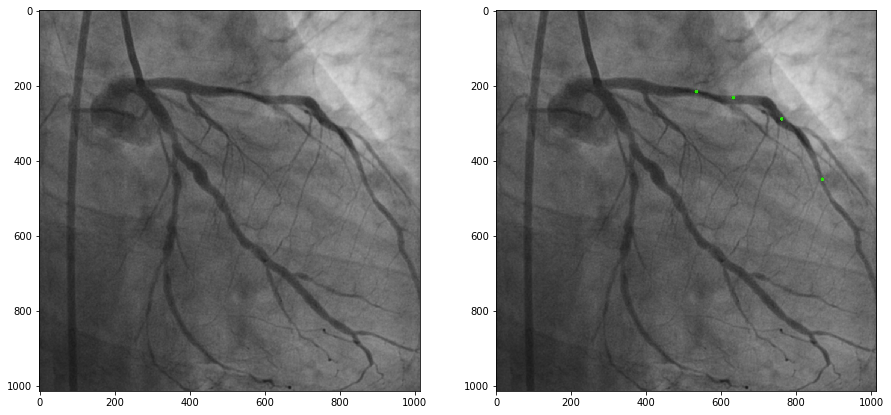

In [3]:
## Check the correspondance between images and raw_images since the data set are not yet sorted

fig,ax=plt.subplots(1,2,figsize=[15,15])
ax[0].imshow(raw_images[101])
ax[1].imshow(images[101])
plt.show()


## *Binarize the images*

In [4]:
# Binarize our images regarding pixel RGB values, values found with data analysis on ImageJ

def binarize_RGB(im_np):
#GD_Rtresh: Green Dot Red channel tresholds [min, max]
    GD_Rtresh=[32,89]
    GD_Gtresh=[86,233]
    GD_Btresh=[0,73]

    RD_Rtresh=[81,232]
    RD_Gtresh=[25,50]
    RD_Btresh=[21,51]


    GD_im_bin_R = (GD_Rtresh[0]<im_np[:,:,0]) & (im_np[:,:,0]<GD_Rtresh[1])
    GD_im_bin_G = (GD_Gtresh[0]<im_np[:,:,1]) & (im_np[:,:,1]<GD_Gtresh[1])
    GD_im_bin_B = (GD_Btresh[0]<im_np[:,:,2]) & (im_np[:,:,2]<GD_Btresh[1])

    GD_im_bin = (GD_im_bin_R & GD_im_bin_G & GD_im_bin_B) * 255

    RD_im_bin_R = (RD_Rtresh[0]<im_np[:,:,0]) & (im_np[:,:,0]<RD_Rtresh[1])
    RD_im_bin_G = (RD_Gtresh[0]<im_np[:,:,1]) & (im_np[:,:,1]<RD_Gtresh[1])
    RD_im_bin_B = (RD_Btresh[0]<im_np[:,:,2]) & (im_np[:,:,2]<RD_Btresh[1])

    RD_im_bin = (RD_im_bin_R & RD_im_bin_G & RD_im_bin_B) * 255
    im_bin=GD_im_bin+RD_im_bin
    return im_bin

In [5]:
### binarize a black and white image to binary 0/1 image
def binarize_BW(im_np):
    tresh=3*10e-20
    im_bin=(tresh<im_np)*1
    return im_bin


## *Match pixels corresponding to culprit regions*

In [8]:
# This algorithm will detect the culprit region on each image and build clusters corresponding to each one,
# so we can separate an image in different ones depending on the number of detected regions. In ID_XY will be the
# coordinates of each cuprit pixel in the middle of such region ofr all images. 

from scipy.cluster.hierarchy import centroid, fcluster
from scipy.spatial.distance import pdist
path_input='/home/thiallie/data/'

ID_XY = {}
p=1
for id_image in tqdm(os.listdir(path_input+'raw/')):
    if id_image[-1] !='g': continue
    if  os.path.isfile(path_input+'labelled/'+'Inked'+'.'.join(id_image.split('.')[:-1])+'_LI.jpg'):

        image=np.array(Image.open(path_input+'labelled/'+'Inked'+'.'.join(id_image.split('.')[:-1])+'_LI.jpg'))
        raw_image=np.array(Image.open(path_input+'raw/'+id_image))
        nb_points = np.shape(np.where(binarize_RGB(image)))[1]

        if nb_points<2:
            continue

        X ,Y = np.where(binarize_RGB(image))

        data_cl= [[X[ind],Y[ind]] for ind in range(nb_points)]
        y = pdist(np.array(data_cl))
        z = centroid(y)
        cluster= fcluster(z, 20, criterion='distance')
        N =len(np.unique(cluster))      

        for n in range(N):

            x= int(np.sum(np.isin(cluster, n+1)*X)/np.array(np.unique(cluster, return_counts=True))[1,n])
            y= int(np.sum(np.isin(cluster, n+1)*Y)/np.array(np.unique(cluster, return_counts=True))[1,n])
            
            
            
            im= torch.Tensor(np.expand_dims(np.array(raw_image), axis=0))
            if im.shape == torch.Size([1, 1014, 1014, 3]):

                ID_XY['n%d' %(n+1) + '_'+id_image]= np.array([x,y])
                os.chdir('/home/thiallie/data/xy_inputs')
                inputs = Image.fromarray(raw_image.astype(np.uint8))
                inputs.save('n%d' %(n+1) + '_'+id_image)

        targets_bin=np.zeros((1014,1014))
        targets_bin[x,y] = 1
        targets_bin = 255*binarize_BW(gaussian(targets_bin, sigma=10))

        targets =  Image.fromarray(targets_bin.astype(np.uint8))

        os.chdir('/home/thiallie/data/target_xy')
        targets.save('tar_' + 'n%d' %(n+1) + '_'+id_image)

100%|██████████| 380/380 [01:14<00:00,  5.12it/s]


In [9]:
# Coordinates gather in ID_XY are save in a pickle file named 'target_xy.pkl'

os.chdir('/home/thiallie/data/')
f = open("target_xy.pkl","wb")
pickle.dump(ID_XY,f)
f.close()

# Data Loader

In [3]:
# This part is used to load the data. We set a dataset class that will return our inputs X and corresponding target
# y.

from torch.utils.data import DataLoader

class Dataset(torch.utils.data.Dataset):

    def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]
        
        # Since our images are of size 1014x1014 we have to resize them to avoid overflow on GPU. The resizing 
        # should be tuned for a different dataset and could also be for the same as our.
        X = torch.Tensor(np.transpose(np.array(Image.open('data/xy_inputs/'+ID).resize((128,128))),(2,1,0)))     
        y = self.labels[ID]

        return X, y

# Set the device on which we will launch the training: either cuda if you have access to a GPU (with available 
# cuda) or your computer cpu.
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

# Parameters
params = {'batch_size': 1,
          'shuffle': False,
          'num_workers': 0}
max_epochs = 2


# Datasets loading: the files are loaded from our personal directories ('data/xy_inputs/' and "data/target_xy.pkl"),
# so you have to change to your own directories or let it like this if it's the same names.

# To observe overfitting of the neural net, only one image is taken into consideration here, but to train on more
# images, you can write this line instead: data_id=[id_image for id_image in os.listdir('data/xy_inputs/')]
data_id=[os.listdir('data/xy_inputs/')[12]]

partition = {}
partition['train'] = data_id[:len(data_id)] # ID of images for training
partition['validation'] = data_id[:len(data_id)] # ID of images for testing (here testing=training)

labels = pickle.load( open( "data/target_xy.pkl", "rb" )) # Labels gathers coordinates to predict for each image
    

# Generators of training and validtion set with batch_size=1
training_set = Dataset(partition['train'], labels)
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set = Dataset(partition['validation'], labels)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)
batch_size=1
dataloaders = {
    'train': DataLoader(training_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(validation_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

# NN implementation

In [4]:
# The neural net for regression is implemented with 64 in and out channels, 3x3 kernels and 1 padding for each 
# convolution layer. The linear sequence is tuned depending on the size of the input image and the kernel chosen
# for convolution.

class LOADnet2(nn.Module):
    
    def __init__(self, skip_connections=True, depth=10):
        super(LOADnet2, self).__init__()
        self.conv = nn.Conv2d(3, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv_seqn = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True)
        )

        self.fc_seqn = nn.Sequential(
            nn.Linear(262144,512),
            nn.ReLU(inplace=True),
            nn.Linear(512,256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv(x)))
        
        ## THE REGRESSION SECTION:
        x2 = self.conv_seqn(x)
        x2 = self.conv_seqn(x2)
        
        # flatten
        x2 = x2.view(x.size(0), -1)
        
        x2 = self.fc_seqn(x2)
        return x2

# Training launcher

In [5]:
from collections import defaultdict
import torch.nn.functional as F

# Function used to print the loss for each epoch

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))
    

# Training function

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e3
    
    # Loss function used is the MSE 
    loss_regression = nn.MSELoss()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()
        scheduler.step()
        
        for param_group in optimizer.param_groups:
            print("LR", param_group['lr'])
        metrics = defaultdict(float)
        epoch_samples = 0

        # For each inputs and labels in our training dataset we train our NN 
        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward and 

            outputs = model(inputs)

            labels=labels.to(torch.float32)
            loss = loss_regression(outputs, labels)
            metrics['loss'] += loss.data.cpu().numpy() * labels.size(0)

            # backward + optimize 
            loss.backward()
            optimizer.step()

            # statistics
            epoch_samples += inputs.size(0)
        
        # Print loss for each epoch
        print_metrics(metrics, epoch_samples, 'train')
        epoch_loss = metrics['loss'] / epoch_samples
        
        # Save the best loss obtain to feed the final model with the model giving this best loss
        best_loss = epoch_loss
        best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

# Training of the model

In [247]:
# Set the device used
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

# Load the model
model = LOADnet2().to(device)

# The optimizer used is the Adam one (an adaptive optimizer) 
optimizer_ft = optim.Adam(model.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=50, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=5a)

cuda:1
Epoch 0/4
----------
LR 0.01
train: loss: 180662.812500
0m 0s
Epoch 1/4
----------
LR 0.01
train: loss: 2733006.750000
0m 0s
Epoch 2/4
----------
LR 0.01
train: loss: 196261.718750
0m 0s
Epoch 3/4
----------
LR 0.01
train: loss: 172265.937500
0m 0s
Epoch 4/4
----------
LR 0.01
train: loss: 86919.250000
0m 0s
Best val loss: 86919.250000


# Results visualization

Targeted coordinates:
tensor([540, 264])
Output coordinates:
tensor([540.1445, 264.4874], device='cuda:1', grad_fn=<SelectBackward>)


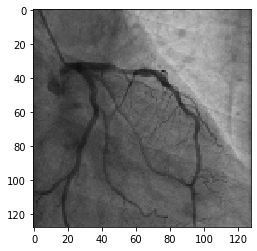

In [245]:
# Load the input and targets used for validation
inputs, targets = next(iter(dataloaders['val']))
output=model(inputs.to(device))

# We plot the input image to see what it looks like
plt.imshow(np.transpose(inputs[0].detach().cpu().numpy().astype(int)), cmap='gray')

# We print the targeted coordinates and the ones obtained at the output of the NN
print('Targeted coordinates:')
print(targets[0])
print('Output coordinates:')
print(output[0])
